In [1]:
import numpy as np
from numpy import genfromtxt
from rocketpy import Function
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Definindo as funções para manipução de dados das canards

In [2]:
class Canard:
    def __init__(self, n, span, rootChord, tipChord, radius, airfoil):
        self.n = n
        self.span = span
        self.rootChord = rootChord
        self.tipChord = tipChord
        self.radius = radius
        self.airfoil = airfoil
        
        self.area = np.pi * radius**2
        self.addFins()

    def addFins(self):
        # Retrieve parameters for calculations
        Af = (self.rootChord + self.tipChord) * self.span / 2  # fin area
        AR = 2 * (self.span ** 2) / Af  # Aspeself.tipChord ratio
        gamac = np.arctan((self.rootChord - self.tipChord) / (2 * self.span))  # mid chord angle

        # Import the lift curve as a funself.tipChordion of lift values by attack angle
        read = genfromtxt(self.airfoil, delimiter=",")
        cnalfa0 = Function(read, extrapolation="natural").differentiate(0, 1e-01)

        # Calculate clalpha
        FD = 2 * np.pi * AR / (cnalfa0 * np.cos(gamac))
        clalpha = (
            cnalfa0
            * FD
            * (Af / self.area)
            * np.cos(gamac)
            / (2 + FD * (1 + (4 / FD ** 2)) ** 0.5)
        )

        # Aplies number of fins to lift coefficient
        clalpha *= self.n / 2

        # Fin–body interference correself.tipChordion
        clalpha *= 1 + self.radius / (self.span + self.radius)

        # self.rootChordeate a funself.tipChordion of lift values by attack angle
        cldata = Function(
            lambda x: clalpha * x, "Alpha (rad)", "Lift coeficient (Cl)", interpolation="linear"
        )

        # Save cldata
        self.cldata = cldata

        # Calculate roll forcing properties
        Ymac = self.radius + self.span / 3 * (self.rootChord + 2 * self.tipChord) / (self.rootChord + self.tipChord)
        clf_delta = clalpha * Ymac / (2 * self.radius)

        clfdata = Function(
            lambda delta: clf_delta * delta, "Delta (rad)", "Roll forcing coeficient (Clf)", interpolation="linear"
        )

        # Save clfdata
        self.clfdata = clfdata

        # Calculate roll damping properties
        b1 = (Ymac /  2) * (self.radius**2) * self.span
        b2 = ((self.rootChord + 2 * self.tipChord) / 3) * self.radius * (self.span**2)
        b3 = ((self.rootChord + 3 * self.tipChord) / 12) * (self.span**3)
        trapezoidal_constant_fins = b1 + b2 + b3

        cld_wv = self.n * cnalfa0 * trapezoidal_constant_fins / (self.area * 2 * self.radius)
        self.cld_data = lambda w, v: cld_wv * w / v

## Inserção de dados

In [3]:
# Dados das aletas
n = 3
span = 0.077
rootChord = 0.058
tipChord = 0.018
airfoil = 'NACA0012 curva Completa.txt'

# Dados das canards
n_canard = 2
span_canard = 0.06
rootChord_canard = 0.035
tipChord_canard = 0.035
airfoil_canard = 'NACA0012 curva Completa.txt'


# Dados do foguete
radius = 80.9/2000

## Criando as aletas e canards

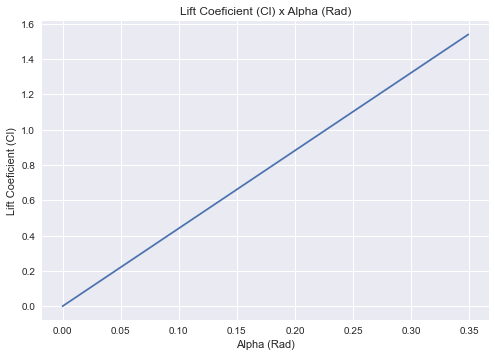

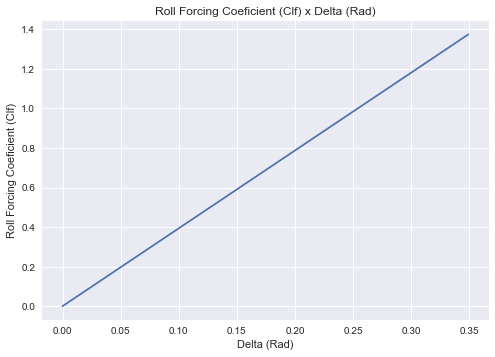

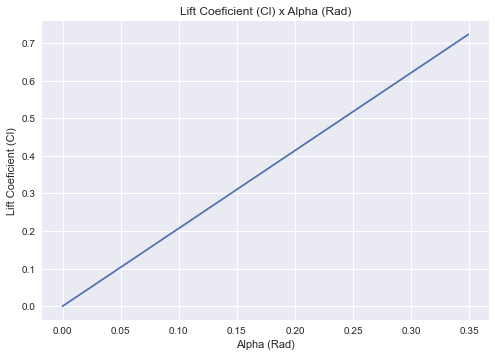

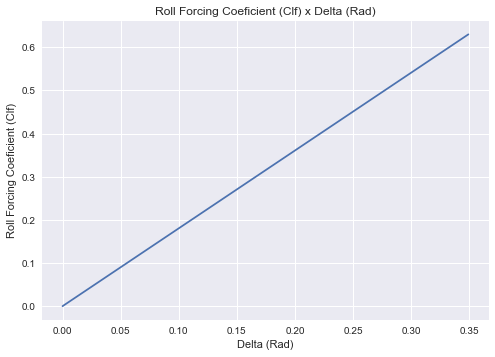

In [4]:
# Criando objeto correspondente à aleta
aleta = Canard(n, span, rootChord, tipChord, radius, airfoil)
canard = Canard(n_canard, span_canard, rootChord_canard, tipChord_canard, radius, airfoil)
aleta.cldata.plot1D(upper= 20 * np.pi / 180)
aleta.clfdata.plot1D(upper= 20 * np.pi / 180)
canard.cldata.plot1D(upper= 20 * np.pi / 180)
canard.clfdata.plot1D(upper= 20 * np.pi / 180)

## Comparação

### Entradas da comparação

In [5]:
# Dados do foguete
J = 0.007 # Momento de inercia (SI)
angulo_maximo_de_abertura = 3 * np.pi / 180
angulo_maximo_de_abertura_canard = 7 * np.pi / 180

# Dados sobre a condição de voo analisada
omega = 0 # rad/s (pior caso para as canards é próximo de 0 sem a ajuda do amortecimento)
velocidade = 0.5 * 343 # Mach 0.5
rho = 1.06 # air density

### Contas

In [6]:
# Parametros das aletas
forcing_aletas = aleta.clfdata(angulo_maximo_de_abertura)
damping_aletas = aleta.cld_data(omega, velocidade)

# Parametros das canards
forcing_canard = canard.clfdata(angulo_maximo_de_abertura_canard)
damping_canard = canard.cld_data(omega, velocidade)

# Parametros de voo
DynamicPressure = velocidade**2 * rho / 2

# Aceleração obtida
Ar = aleta.area # Área de referencia
Lr = 2 * aleta.radius # Comprimento de referencia
omega_dot = (forcing_aletas - forcing_canard - damping_aletas - damping_canard) * DynamicPressure * Ar * Lr / J

print("Aceleração angular para V={:.0f}m/s é: ὡ = {:.2f}rad/s²".format(velocidade, omega_dot))
print("Nota 1: Deseja-se que a aceleração seja negativa para que a canard seja capaz de estabilizar o foguete")

Aceleração angular para V=172m/s é: ὡ = -13.25rad/s²
Nota 1: Deseja-se que a aceleração seja negativa para que a canard seja capaz de estabilizar o foguete
